Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from google.colab import drive
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D ,RandomFlip, RandomRotation, RandomZoom, RandomContrast,Input


In [44]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
drive.mount('/content/gdrive')


##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [40]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [21]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height,img_width),
    batch_size=batch_size
)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [22]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% of data will be used for validation
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

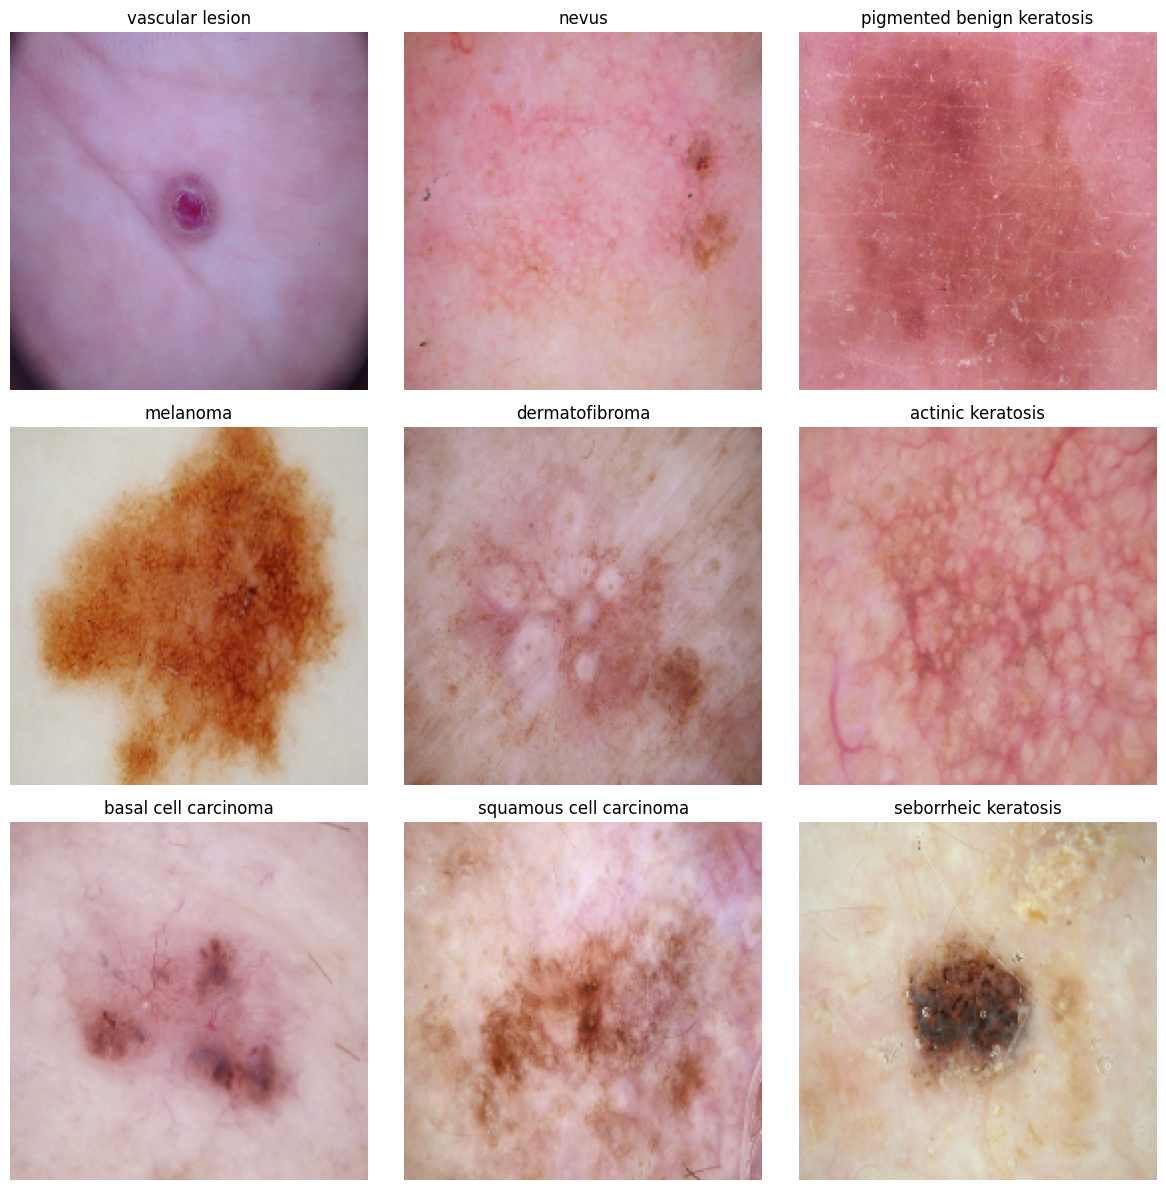

In [9]:
import matplotlib.pyplot as plt
samples_per_class = {}
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in samples_per_class:
            samples_per_class[class_name] = img
        if len(samples_per_class) == len(class_names):
            break
    if len(samples_per_class) == len(class_names):
        break

# Plot images
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(samples_per_class.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
normalization_layer = Rescaling(1.0 / 255)

# Apply normalization to training and validation datasets
train_ds_normal = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_normal = val_ds.map(lambda x, y: (normalization_layer(x), y))

num_classes = 9  # Number of classes

# One-hot encode labels
train_ds_one = train_ds_normal.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds_one = val_ds_normal.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

model = models.Sequential([
    # Input layer and first convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
   # model.add(BatchNormalization())
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    #model.add(BatchNormalization())
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
   # model.add(BatchNormalization())
    layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
   # model.add(Dropout(0.25))
    layers.Dense(9, activation='softmax')  # 9 classes
])

# Display the model's architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds_one,
  validation_data=val_ds_one,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.1896 - loss: 2.0781 - val_accuracy: 0.1499 - val_loss: 2.0342
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2196 - loss: 2.0030 - val_accuracy: 0.2058 - val_loss: 2.0361
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2095 - loss: 2.0116 - val_accuracy: 0.2819 - val_loss: 2.0043
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2538 - loss: 2.0152 - val_accuracy: 0.2998 - val_loss: 1.9789
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2675 - loss: 1.9603 - val_accuracy: 0.2931 - val_loss: 1.9732
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2935 - loss: 1.9422 - val_accuracy: 0.2931 - val_loss: 1.8832
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2950 - loss: 1.9417 - val_accuracy: 0.2729 - val_loss: 1.9713
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2915 - loss: 1.8997 - val_accuracy: 0.3154 - v

### Visualizing training results

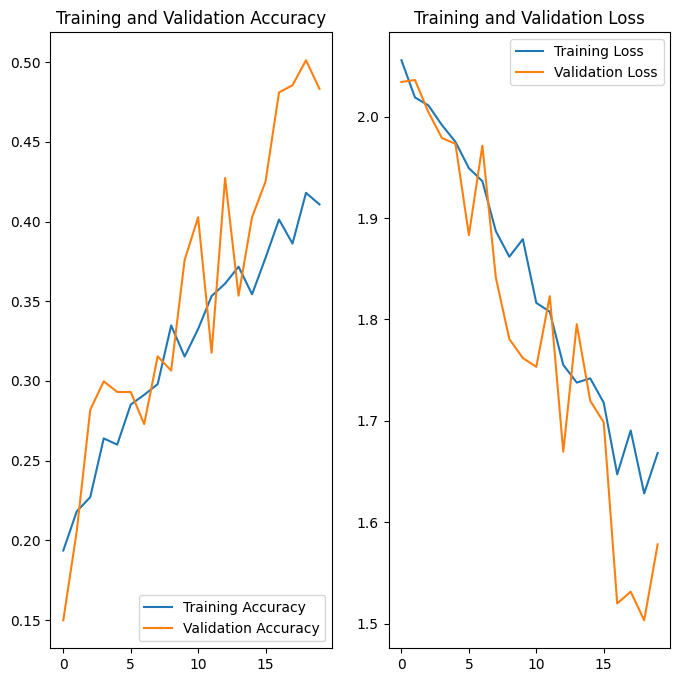

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1.Currently the training model is Underfitting as it's accuracy is 41.95 and the validation accuracy is closer to same

### Todo:
### Create the model, compile and train the model


In [16]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
data_augmentation = Sequential([
    Input(shape=(180, 180, 3)),
    RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    RandomRotation(0.2),                    # Rotate images by up to 20%
    RandomZoom(0.2),                        # Zoom in/out by up to 20%
    RandomContrast(0.2)                     # Adjust contrast by up to 20%
])

model = models.Sequential([
    data_augmentation,
    # Input layer with rescaling
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),  # Apply Batch Normalization here
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),  # Dropout to reduce overfitting
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

# Display the model's architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,073 (57.86 MB)

 Trainable params: 15,167,881 (57.86 MB)

 Non-trainable params: 192 (768.00 B)

### Compiling the model

In [17]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [18]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.2468 - loss: 37.2062 - val_accuracy: 0.1477 - val_loss: 9.9135
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2855 - loss: 15.2805 - val_accuracy: 0.1499 - val_loss: 58.9118
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.3243 - loss: 9.0617 - val_accuracy: 0.1499 - val_loss: 73.1866
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3183 - loss: 4.0825 - val_accuracy: 0.1566 - val_loss: 22.9720
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3331 - loss: 2.5561 - val_accuracy: 0.1521 - val_loss: 25.3629
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3269 - loss: 2.2397 - val_accuracy: 0.1521 - val_loss: 11.7625
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3554 - loss: 2.0948 - val_accuracy: 0.2125 - val_loss: 6.7574
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3906 - loss: 1.9491 - val_accuracy: 0.2707 - val_

### Visualizing the results

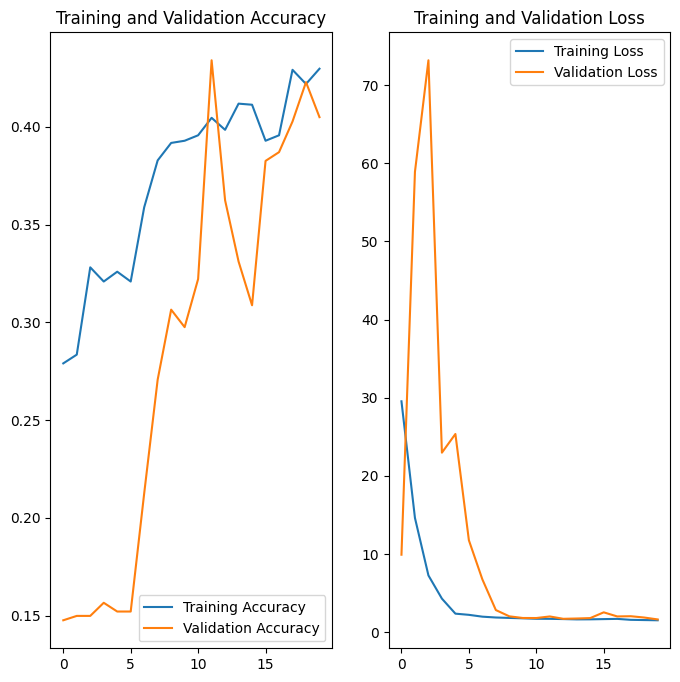

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Currently with Augmentation,Drop out and Batch Normalisation ,there is 2% improvement in accuracy and it is currently 43%

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
Name: count, dtype: int64


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? Seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples? pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C835E5578E0>: 100%|██████████| 500/500 [00:25<00:00, 19.86 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C83907317E0>: 100%|██████████| 500/500 [00:19<00:00, 25.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C83AE514310>: 100%|██████████| 500/500 [00:20<00:00, 24.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C839061EE90>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2155x1958 at 0x7C83906C7970>: 100%|██████████| 500/500 [01:14<00:00,  6.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C83906C4520>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C839061EFB0>: 100%|██████████| 500/500 [00:40<00:00, 12.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C8390733970>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C83906C4520>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list_new)

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001140.jpg_84faefb7-8c68-444c-9dc4-f70260c93e02.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_e18fbd94-233f-4433-9fb1-5a73849c039c.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_10b5bde0-df08-478f-9968-cedeaf52a2c9.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010971.jpg_a2827af4-609c-4083-a5df-8d947fca0b2c.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010486.jpg_d93dc5ae-cb02-457b-961b-8253d858bfdc.jpg', '/content/gdrive/My Drive/Skin cancer ISIC The Internationa

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [31]:
new_df['Label'].value_counts()

,count
Label,
melanoma,500
dermatofibroma,500
squamous cell carcinoma,500
seborrheic keratosis,500
vascular lesion,500
pigmented benign keratosis,500
nevus,500
basal cell carcinoma,500
actinic keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [35]:
model = models.Sequential([
    # Input layer with rescaling
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block (added for depth)
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Increase dropout to reduce overfitting
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

# Display the model's architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,817 (436.79 KB)

 Trainable params: 111,369 (435.04 KB)

 Non-trainable params: 448 (1.75 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [37]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step - accuracy: 0.2996 - loss: 1.8579 - val_accuracy: 0.1166 - val_loss: 2.5860
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 234ms/step - accuracy: 0.4211 - loss: 1.5106 - val_accuracy: 0.1745 - val_loss: 2.7146
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.4541 - loss: 1.4099 - val_accuracy: 0.3177 - val_loss: 1.8305
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 230ms/step - accuracy: 0.4752 - loss: 1.3659 - val_accuracy: 0.4529 - val_loss: 1.4108
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 233ms/step - accuracy: 0.5005 - loss: 1.3118 - val_accuracy: 0.4143 - val_loss: 1.6727
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.5194 - loss: 1.2497 - val_accuracy: 0.2539 - val_loss: 2.5374
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.5329 - loss: 1.2389 - val_accuracy: 0.2725 - val_loss: 2.5239
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.5373 - loss: 1.2115 - val

#### **Todo:**  Visualize the model results

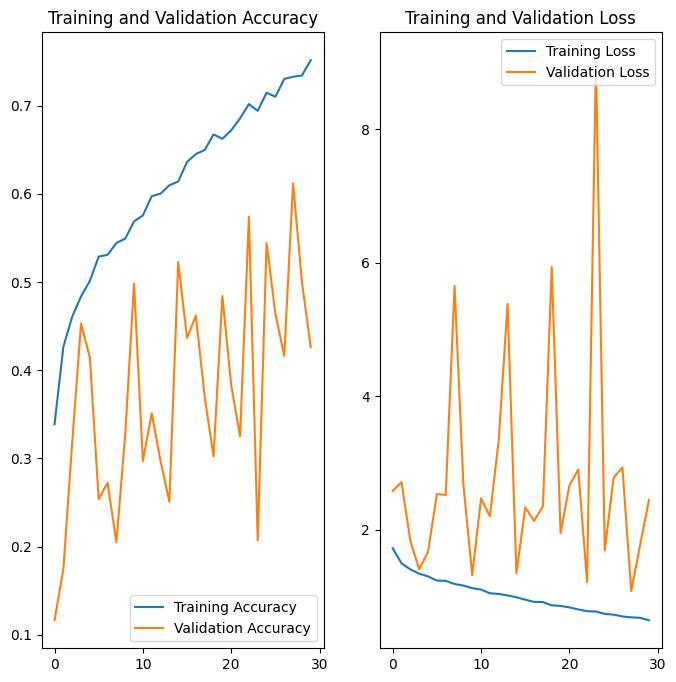

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Currently the model. accuracy is 75 % with overfitting as the validation accuracy is 42% so we need to further train the model to reduce this imperfection

In [43]:
# Load test data

test_ds = image_dataset_from_directory(
    data_dir_test,
    image_size=(180, 180),
    batch_size=32
)

# Evaluate the model on the test set (optional)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Display predictions
print(predicted_classes)

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.3241 - loss: 4.0726
Test Accuracy: 27.12%
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 606ms/step
[4 4 4 6 4 4 3 3 4 5 4 1 4 3 4 1 1 3 4 4 1 4 4 4 3 4 3 3 4 4 4 3 4 4 4 3 5
 4 1 4 4 3 3 4 5 1 4 5 3 3 7 3 4 5 3 5 4 4 4 4 2 8 4 5 4 4 1 5 4 4 4 3 4 4
 5 4 5 4 3 4 3 4 5 1 4 1 3 1 5 3 5 3 3 3 3 4 4 4 3 4 4 3 4 1 8 4 5 3 4 3 4
 3 3 1 4 4 5 4]


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Yes the model is overfitting which will be corrected in future- Test accuracy is 32% and train accuracy is 75%
